In [1]:
import torch.nn.functional as F
import torch
from torch import nn
from dataset import BratsDataset
from training_loop import train_model
from basic_unet import UNet
from torchvision import transforms
from pathlib import Path
from torch.utils.data import DataLoader
from torch import optim
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import numpy as np

In [2]:
BATCH_SIZE = 1

def load_dataset():
    transform = transforms.Compose([])
    train_dataset = BratsDataset(Path('data/processed'), transform=transform, test=False)
    test_dataset = BratsDataset(Path('data/processed'), transform=transform, test=True)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    return train_loader, test_loader

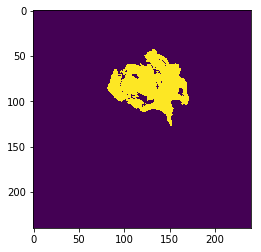

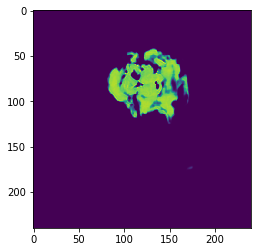

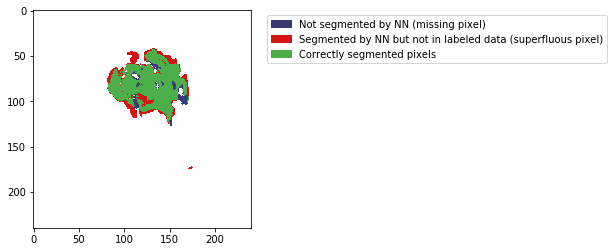

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_loader, test_loader = load_dataset()

model = UNet(in_channels=4, out_channels=1)
state_dict = torch.load('models/3_basic_unet_flat_criterion_279_0.00000.pth')
model.load_state_dict(state_dict)
model = model.to(device)

COLOR_LABEL = '#393B79' # 1 = blue, only on label segment
COLOR_NETWORK = '#d61313' # 2 = red, only on network output
COLOR_BOTH = '#4DAF4A' # 3 = green, on both segments

cmap = ListedColormap(colors=[
    (1.0, 1.0, 1.0),
    COLOR_LABEL,
    COLOR_NETWORK,
    COLOR_BOTH,
])

for sample in test_loader:
    segment = sample['segment']
    segment = segment.squeeze()
    plt.imshow(segment)
    plt.show()

    image = sample['input'].to(device)
    output = model(image)
    output = output.detach().cpu().squeeze().numpy()
    plt.imshow(output)
    plt.show()
    
    output_threshold = (output > output.mean()).astype(int)
    segment_threshold = (segment.numpy() > 0).astype(int)

    plt.imshow(output_threshold * 2 + segment_threshold, cmap=cmap)
    label_patch = mpatches.Patch(color=COLOR_LABEL, label='Not segmented by NN (missing pixel)')
    network_patch = mpatches.Patch(color=COLOR_NETWORK, label='Segmented by NN but not in labeled data (superfluous pixel)')
    both_patch = mpatches.Patch(color=COLOR_BOTH, label='Correctly segmented pixels')
    plt.legend(handles=[label_patch, network_patch, both_patch], loc=2, bbox_to_anchor=(1.05, 1))
    plt.show()
    break